In [247]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from matplotlib import pyplot as plt
from progressbar import ProgressBar
print("Modules Imported")

Modules Imported


In [0]:
def create_dataframe(subjects):
    results_data = pd.DataFrame(columns = ['Roll No.', 'Name', ] + subjects + ['Result'])            # Returns an empty dataframe
    return results_data

In [0]:
def append_dataframe(results_data,name,sgpa,rno,subjects,grades):
    data = dict(zip(subjects,grades))                                                                # Creating a dict    
    data['Name'] = name                                                                              # Appending three new k,v to the dict
    data['Roll No.'] = rno
    data['Result'] = sgpa                                                                                                    
    temp_dataframe = pd.DataFrame(data, columns = ['Roll No.', 'Name', ] +\
                                  subjects + ['Result'], index = [rno%1000,])                        # Creating a temp dataframe with only one row and same structure (columns) as that of results_data                                
    results_data = results_data.append(temp_dataframe, sort = False)                                 # Appending the new dataframe to results_data
    return results_data

In [0]:
def fetch_result(starting_roll, ending_roll, url):
    pbar = ProgressBar()                                                                            # Defines a progress bar object
    for rno in pbar(range(starting_roll, ending_roll+1)):
        try:
            with requests.session() as sess:
                page = sess.post(url, data = {'htno':rno, 'mbstatus':'SEARCH'})                     # Posting htno and CSRF token to the JSP
                soup = BeautifulSoup(page.content,'html.parser')                                    # Converting into a BeautifulSoup Object for html parsing

                # Fetching student name
                name_table = soup.find(id = 'AutoNumber3')                                          # Find the table with student details (name, fname etc)
                name_rows = name_table.find_all('tr')                                               # Dividing the table into list of rows
                name_row = name_rows[2].find_all('td')                                              # Row 3 (indexed 2) has name, so divide row-3 into columns
                name = name_row[1].get_text()                                                       # Since name is in 2nd column (indexed 1)

                # Fetching student scores for each subject
                subjects = []                                                                       # We'll store subject names here
                grades = []                                                                         # This is for grade points for same indexed subject in subjects[]
                score_table = soup.find(id = 'AutoNumber4')                                         # Find the table with score
                score_rows = score_table.find_all('tr')                                             # Dividing the table into a list of rows
                for row in range(2 , len(score_rows)):                                              # Since actual data starts from row 3 (indexed 2)
                    score_cols = score_rows[row].find_all('td')                                     # Dividing each row into columns
                    subjects.append(str(score_cols[1].get_text()).lstrip('\xa0'))                   # Extracting subject from column 2 (indexed 1) and removing escape chars\
                    grades.append(str(score_cols[3].get_text()).lstrip('\xa0'))                     # Extracting the score for the same subject and removing escape chars\
        
                # Fetching final result and SGPA
                result_table = soup.find( id = 'AutoNumber5')                                       # Find the table with final result
                result_rows = result_table.find_all('tr')                                           # Dividing the table into a list of rows
                result_row = result_rows[-1].find_all('td')                                         # Generally Row 3 (indexed 2) has sgpa (or last row in case of 'promoted' case), so divide row-3 into columns
                sgpa = str(result_row[2].get_text()).strip()                                        # Extract sgpa from column 3 (indexed 2)  
        
                
                if rno == starting_roll:                                                            # If its the first iteration create a new empty data frame
                    results_data = create_dataframe(subjects)
                
                
                results_data = append_dataframe(results_data,name,sgpa\
                                                    ,rno%1000000,subjects,grades)                   # If its not the first iteration, append new rows to the existing dataframe      
                
        except :
            print('\n' + str(rno) + " - Doesn't exists")
            
            
        finally:
            if rno == ending_roll:                                                                  # Return the completed DataFrame - Last roll may cause an exception so finally-block
                return results_data

In [0]:
def visualize(dataframe):

    unprocessed_gpa = dataframe['Result'].tolist()                                                     # Creating a list of SGPAs
    sgpa = []
    for gpa in unprocessed_gpa:
        if gpa == 'PROMOTED--' or gpa == 'PROMOTED':
            sgpa.append(float(0.05))
        elif gpa == 'DETAINED':
            sgpa.append(float(-0.05))
        else:
            sgpa.append(float(gpa[7:len(gpa)+1]))                                                      # Fetching float values from result Eg : 'PASSED-8.64'

    unprocessed_rolls = dataframe['Roll No.'].tolist()                                                 # Creating a list of roll numbers (less digits) 
    rolls = []
    for roll in unprocessed_rolls:
        rolls.append(int(roll%1000))

    plt.figure(num=None, figsize=(22, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("Roll Number", fontsize = 17)
    plt.ylabel("SGPA", fontsize = 17)
    plt.title("Result from  " + str(rolls[0]) + " - " + str(rolls[-1]), fontsize = 20) 
    plt.xticks(rolls)                                                                                  # for displaying each point on x-axis
    
    for i in range(0,len(sgpa)):                                                                       # Plotting GPAs 
        if sgpa[i] == 10.0:
            plt.bar(rolls[i],sgpa[i], color ='#FFD700')
        elif sgpa[i] >= 9.0 and sgpa[i] < 10.0:
            plt.bar(rolls[i],sgpa[i], color ='#880d1e')
        elif sgpa[i] >= 8.0 and sgpa[i] < 9.0:
            plt.bar(rolls[i],sgpa[i], color ='#dd2c44')
        elif sgpa[i] >= 7.0 and sgpa[i] < 8.0:
            plt.bar(rolls[i],sgpa[i], color ='#f26a7c')
        elif sgpa[i] >= 6.0 and sgpa[i] < 7.0:
            plt.bar(rolls[i],sgpa[i], color ='#f49ca8')
        elif sgpa[i] >= 5.0 and sgpa[i] < 6.0:
            plt.bar(rolls[i],sgpa[i], color ='#f2cbd0')
        elif sgpa[i] == 0.05:
            plt.bar(rolls[i],sgpa[i], color ='c')
        elif sgpa[i] == -0.05:
            plt.bar(rolls[i],sgpa[i], color ='k', label='DETAINED')
    
    plt.legend()                                                                                       # Display the legend
    plt.savefig('Results-Bar-Graph.png', dpi = 80)
    plt.show()
    print("Bar-graph created!")

In [0]:
def main():

    while(True):
        starting_roll = int(input("Enter the starting roll number : "))
        ending_roll = int(input("Enter the last roll number : "))
        range_ = ending_roll - starting_roll
        if(range_ < 0 or range_ > 120):
            print('Please check the roll numbers - you can seach for atleast 1 student and atmost 120 students at a time!')
        else:
            break
    
    url = input("Paste the link to the results : ")

    print("Fetching Results!")
    dataframe = fetch_result(starting_roll,ending_roll,url)
    
        
    visualize(dataframe)
    print()

    names = dataframe['Name'].tolist()                                                             # Generating lists of names, rolls and GPAs
    rolls = dataframe['Roll No.'].tolist()
    gpa = dataframe['Result'].tolist()

    print("Found " + str(len(names)) + " student(s) between the given roll numbers")
    for i in range(len(names)):
        print(str(rolls[i]) + " : " + str(names[i]) + " : " + str(gpa[i]))

    dataframe.to_csv("Results.csv")
    print("Results.csv created!")

Enter the starting roll number : 160417737061
Enter the last roll number : 160417737116
Paste the link to the results : https://www.osmania.ac.in/res07/20190318.jsp


N/A% (0 of 56) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Fetching Results!


 37% (21 of 56) |#########               | Elapsed Time: 0:00:28 ETA:   0:00:44


160417737081 - Doesn't exists


 98% (55 of 56) |####################### | Elapsed Time: 0:01:12 ETA:   0:00:01

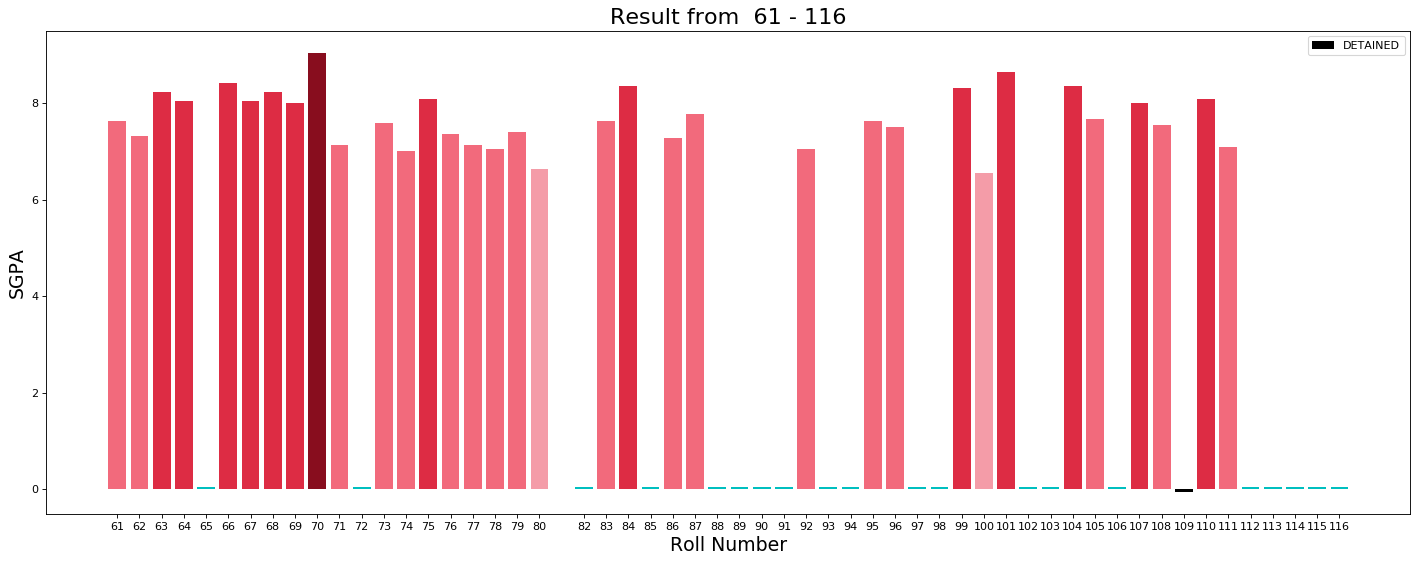

Bar-graph created!

Found 55 student(s) between the given roll numbers
737061 :  SAYEDA AMENA ZUHA : PASSED-7.64
737062 :  RUHI AYESHA : PASSED-7.32
737063 :  ZEHRA FATIMA NAQVI : PASSED-8.23
737064 :  SYEDA SUFIA JABEEN : PASSED-8.05
737065 :  SABA SULTANA : PROMOTED--
737066 :  SYEDA RUQHAIYA FATIMA : PASSED-8.41
737067 :  MADIHA FATIMA : PASSED-8.05
737068 :  SARA MATEEN : PASSED-8.23
737069 :  FOUZIYA SULTANA : PASSED-8
737070 :  SUMERA TAHREEN : PASSED-9.05
737071 :  INA ABDUL HAKEEM SYED : PASSED-7.14
737072 :  ALISHA TAJMEEM : PROMOTED--
737073 :  SAYYADA HAFSA AHSAN : PASSED-7.59
737074 :  ARJUMAND SAKINA : PASSED-7
737075 :  RUHI NAAZ : PASSED-8.09
737076 :  MASEERAH MAHBOOB KHATOON : PASSED-7.36
737077 :  SHAZIA FATIMA : PASSED-7.14
737078 :  JUVERIA FATIMA : PASSED-7.05
737079 :  SYEDA ZAREEN FATIMA : PASSED-7.41
737080 :  AKIF AHMED : PASSED-6.64
737082 :  MOHAMMED TALHA : PROMOTED--
737083 :  MOHAMMED SAAD SUBHAN : PASSED-7.64
737084 :  MOHAMMED TAHOOR AHMED : PASSED-8.36


In [253]:
main()